In [72]:
# 必要なもの

# 処理系
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# タイトルの単語列を特徴量として割り当てる
from sklearn.feature_extraction.text import CountVectorizer

# ロジスティック回帰
from sklearn.linear_model import LogisticRegression

# 混同行列、他
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# 複数リストの組み合わせ
import itertools

50. データの入手・整形

[News Aggregator Data Set](https://archive.ics.uci.edu/ml/datasets/News+Aggregator)をダウンロードし、以下の要領で学習データ（train.txt），検証データ（valid.txt），評価データ（test.txt）を作成せよ．

- ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む．
- 情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．
- 抽出された事例をランダムに並び替える．
- 抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ（このファイルは後に問題70で再利用する）．

学習データと評価データを作成したら，各カテゴリの事例数を確認せよ．

In [33]:
# csvとして読み取り、namesにヘッダを追加
df = pd.read_csv('news+aggregator/newsCorpora.tsv', sep='\t', header=0, names=['TITLE','URL','PUBLISHER','CATEGORY','STORY','HOSTNAME','TIMESTAMP'])

# 情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する
valid_publishers = ["Reuters", "Huffington Post", "Businessweek", "Contactmusic.com", "Daily Mail"]
df_publisher = df[df['PUBLISHER'].isin(valid_publishers)]
df_publisher

# 抽出された事例をランダムに並び替える
df_shuffle = df_publisher.sample(frac=1)
df_shuffle

# 抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する
length = len(df_shuffle)
eighty = (length//100)*80
ninety = (length//100)*90
(train,valid,test) = (df_shuffle[:eighty],df_shuffle[eighty:ninety],df_shuffle[ninety:])

# 分割したデータを保存
train.to_csv("data/train.txt",columns=['CATEGORY', 'TITLE'],sep='\t',header=False, index=False)
valid.to_csv("data/valid.txt",columns=['CATEGORY', 'TITLE'],sep='\t',header=False, index=False)
test.to_csv("data/test.txt",columns=['CATEGORY', 'TITLE'],sep='\t',header=False, index=False)

# 学習データと評価データを作成したら，各カテゴリの事例数を確認する
print(train.groupby("CATEGORY").size(),valid.groupby("CATEGORY").size())
print(df_shuffle['CATEGORY'].value_counts())

CATEGORY
b    4518
e    4178
m     721
t    1223
dtype: int64 CATEGORY
b    535
e    557
m     93
t    145
dtype: int64
CATEGORY
b    5627
e    5278
t    1524
m     910
Name: count, dtype: int64


51. 特徴量抽出

学習データ，検証データ，評価データから特徴量を抽出し，それぞれtrain.feature.txt，valid.feature.txt，test.feature.txtというファイル名で保存せよ． なお，カテゴリ分類に有用そうな特徴量は各自で自由に設計せよ．記事の見出しを単語列に変換したものが最低限のベースラインとなるであろう．

In [34]:
v = CountVectorizer()

# モデルに流すデータには基本的に同じ幅を持たせたい
# 最初にfit_transformを実行して最大値と最小値を決めると同時に正規化
# 検証用と評価用は制限があるのでその中で正規化、つまりtransformだけ
# 全部同じ関数で正規化してしまうと訓練したモデルに評価データが入らない

X_train = v.fit_transform(train['TITLE'].to_numpy())
X_valid = v.transform(valid['TITLE'].to_numpy())
X_test = v.transform(test['TITLE'].to_numpy())

np.savetxt('data/train.feature.txt', X_train.toarray(), fmt='%d')
np.savetxt('data/valid.feature.txt', X_valid.toarray(), fmt='%d')
np.savetxt('data/test.feature.txt', X_test.toarray(), fmt='%d')

52. 学習

51で構築した学習データを用いて，ロジスティック回帰モデルを学習せよ．

In [35]:
# 先ほどの単語ベクトルを入力データ、カテゴリを正解データとしてモデルの訓練をする
clf = LogisticRegression(random_state=0).fit(X_train, train['CATEGORY'])

/Users/taketsunaichiyanagi/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


53. 予測

52で学習したロジスティック回帰モデルを用い，与えられた記事見出しからカテゴリとその予測確率を計算するプログラムを実装せよ．

In [36]:
# N番目までのカテゴリと予測精度
N = 10
print('予測：', clf.predict(X_train[:N,:]))
# 確率とは予測精度のこと、例えば先頭データについては99%の確率でmと言っている
print('確率：', [str(round(i*100))+'%' for i in clf.predict_proba(X_train[:N,:]).max(axis=1)])
print('正解：', train['CATEGORY'][:N].to_numpy())
print('精度：', clf.score(X_train[:N,:],train['CATEGORY'][:N]))

予測： ['m' 'e' 'b' 't' 'b' 'm' 'e' 'e' 'e' 'b']
確率： ['99%', '98%', '98%', '66%', '100%', '90%', '94%', '80%', '89%', '80%']
正解： ['m' 'e' 'b' 't' 'b' 'm' 'e' 'e' 'e' 'b']
精度： 1.0


54. 正解率の計測

52で学習したロジスティック回帰モデルの正解率を，学習データおよび評価データ上で計測せよ．

In [37]:
# それぞれの精度
# 学習済モデルに訓練データを突っ込んでも100%になるわけではない
print('訓練：', clf.score(X_train,train['CATEGORY']))
print('評価：', clf.score(X_test,test['CATEGORY']))

訓練： 0.9964285714285714
評価： 0.9116143170197224


55. 混同行列の作成

52で学習したロジスティック回帰モデルの混同行列（confusion matrix）を，学習データおよび評価データ上で作成せよ．

In [38]:
# 予測データと正解データとの混合行列
y_train_predict = clf.predict(X_train)
y_test_predict = clf.predict(X_test)

# テストデータはまだ精度が甘く、データの混同が大きい
print(confusion_matrix(train['CATEGORY'], y_train_predict))
print(confusion_matrix(test['CATEGORY'], y_test_predict))

[[4508    2    0    8]
 [   6 4170    0    2]
 [   5    1  715    0]
 [  12    2    0 1209]]
[[549  15   2   8]
 [  7 530   3   3]
 [ 11  20  59   6]
 [ 24  20   2 110]]


56. 適合率，再現率，F1スコアの計測

52で学習したロジスティック回帰モデルの適合率，再現率，F1スコアを，評価データ上で計測せよ．カテゴリごとに適合率，再現率，F1スコアを求め，カテゴリごとの性能をマイクロ平均（micro-average）とマクロ平均（macro-average）で統合せよ．

In [39]:
# 適合率
print(precision_score(test['CATEGORY'], y_test_predict, average='macro'),precision_score(test['CATEGORY'], y_test_predict, average='micro'))
# 再現率
print(recall_score(test['CATEGORY'], y_test_predict, average='macro'),recall_score(test['CATEGORY'], y_test_predict, average='micro'))
# f1スコア
print(f1_score(test['CATEGORY'], y_test_predict, average='macro'),f1_score(test['CATEGORY'], y_test_predict, average='micro'))

0.8987495105895122 0.9116143170197224
0.8130541158382336 0.9116143170197224
0.8469964507954999 0.9116143170197224


57. 特徴量の重みの確認

52で学習したロジスティック回帰モデルの中で，重みの高い特徴量トップ10と，重みの低い特徴量トップ10を確認せよ．

[[ 0.0525578   0.01828987  0.00292138 ... -0.07098878 -0.04807168
  -0.00108514]
 [-0.03362413 -0.01189816 -0.00153418 ...  0.13099771  0.10688934
   0.00398011]
 [-0.00857174 -0.0020771  -0.00086191 ... -0.02085208 -0.0229664
  -0.00100396]
 [-0.01036194 -0.00431461 -0.00052529 ... -0.03915686 -0.03585126
  -0.00189101]]


<Axes: >

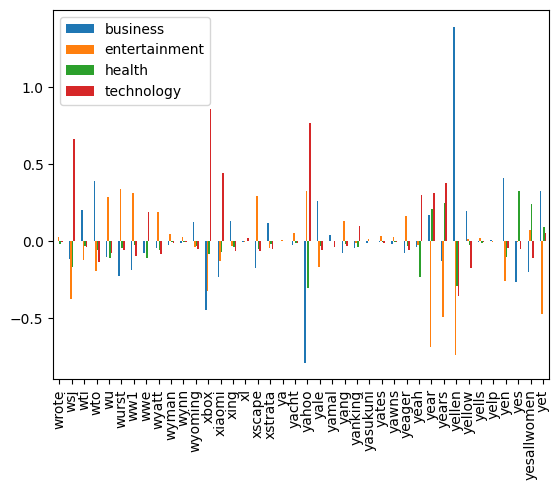

In [58]:
print(clf.coef_)

# リストの後ろの方40個ほどを取り出してみた結果
# yellen は business にかなり強く結びついてる
# xbox は entertainment に関係性がある、などのことがわかる
(start,end) = (-100,-60)
df = pd.DataFrame(clf.coef_[:,start:end].T,columns=['business','entertainment','health','technology'],index=v.get_feature_names_out()[start:end])

df.plot.bar()


58. 正則化パラメータの変更

ロジスティック回帰モデルを学習するとき，正則化パラメータを調整することで，学習時の過学習（overfitting）の度合いを制御できる．異なる正則化パラメータでロジスティック回帰モデルを学習し，学習データ，検証データ，および評価データ上の正解率を求めよ．実験の結果は，正則化パラメータを横軸，正解率を縦軸としたグラフにまとめよ．

/Users/taketsunaichiyanagi/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/taketsunaichiyanagi/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

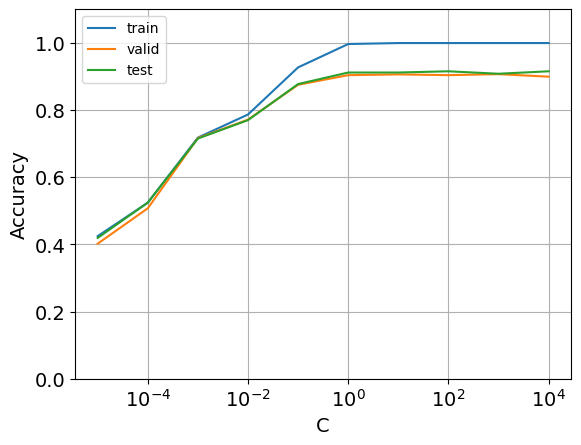

In [71]:
# Cをいじる(default:1.0)
# 正則化を弱めたことで全体的に精度が下がった
# つまり今回のような大量の特徴量を持つデータに対しては正則化は有効？

# 得られた正則化パラメータでロジスティック回帰モデルで学習を行う
def calc_acc(c):

    clf = LogisticRegression(C=c)
    clf.fit(X_train, train['CATEGORY'])
    
    return [
        clf.score(X_train, train['CATEGORY']),
        clf.score(X_valid, valid['CATEGORY']),
        clf.score(X_test, test['CATEGORY'])
    ]

# 正則化パラメータを10^-5~10^4で網羅する
C = np.logspace(-5, 4, 10, base=10)

scores = []
for c in C:
    scores.append(calc_acc(c))

# 各データでのグラフにするために全正則化パラメータでの結果について行と列を入れ替える
scores = np.array(scores).T
labels = ['train', 'valid', 'test']

for score, label in zip(scores,labels):

    # パラメータと各データとの折れ線グラフ
    plt.plot(C, score, label=label)

plt.ylim(0, 1.1)
plt.xscale('log')
plt.xlabel('C', fontsize = 14)
plt.ylabel('Accuracy', fontsize = 14)
plt.tick_params(labelsize=14)
plt.grid(True)
plt.legend()

59. ハイパーパラメータの探索

学習アルゴリズムや学習パラメータを変えながら，カテゴリ分類モデルを学習せよ．検証データ上の正解率が最も高くなる学習アルゴリズム・パラメータを求めよ．また，その学習アルゴリズム・パラメータを用いたときの評価データ上の正解率を求めよ．

In [74]:
# 先ほどのコードについて、学習アルゴリズム・学習パラメータを追加する
def calc_acc(c,solver,class_weight):

    clf = LogisticRegression(C=c, solver=solver, class_weight=class_weight)
    clf.fit(X_train, train['CATEGORY'])
    
    return [
        clf.score(X_train, train['CATEGORY']),
        clf.score(X_valid, valid['CATEGORY']),
        clf.score(X_test, test['CATEGORY'])
    ]

# 学習アルゴリズム、正則化パラメータ、学習パラメータを全パターン用意
solver = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
C = np.logspace(-5, 4, 10, base=10)
class_weight = [None,'balanced']

best_score = 0
best_score_test = None
best_param = None

for c,s,cw in itertools.product(C,solver,class_weight):

    scores = calc_acc(c, s, cw)
    if scores[1] > best_score:

        # 全パターンについて学習を行い、最もスコアが高いものをベストスコアとして更新していく
        best_score = scores[1]
        best_score_test = scores[2]
        best_param = (c,s,cw)

print('最高の組み合わせとその正解率：',best_param,best_score)
print('そのパラメータを用いたときの評価データの正解率',best_score_test)

/Users/taketsunaichiyanagi/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/taketsunaichiyanagi/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/taketsunaichiyanagi/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/taketsunaichiyanagi/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/taketsunaichiyanagi/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOT

最高の組み合わせとその正解率： (10.0, 'liblinear', 'balanced') 0.9165413533834587
そのパラメータを用いたときの評価データの正解率 0.9225712198685172


/Users/taketsunaichiyanagi/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### 結果

- 最高の組み合わせとその正解率： (10.0, 'liblinear', 'balanced') 0.9165413533834587
- そのパラメータを用いたときの評価データの正解率 0.9225712198685172